In [1]:
from datetime import datetime, timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
import metpy.plots as mpplots
from siphon.catalog import TDSCatalog
import numpy as np

In [2]:
dt = datetime.utcnow()

In [3]:
rtma_cat = TDSCatalog('https://thredds.ucar.edu/thredds/catalog/grib/NCEP/RTMA/CONUS_2p5km/catalog.xml')
rtma_data = rtma_cat.datasets['Full Collection Dataset'].remote_access(use_xarray=True)
rtma_data = rtma_data.metpy.parse_cf()

In [4]:
pres = rtma_data['Pressure_Analysis_surface'].metpy.sel(time=dt, method='nearest').squeeze()
temp = rtma_data['Temperature_Analysis_height_above_ground'].metpy.sel(time=dt, method='nearest').squeeze()
dewp = rtma_data['Dewpoint_temperature_Analysis_height_above_ground'].metpy.sel(time=dt, method='nearest').squeeze()

In [5]:
thetae = mpcalc.equivalent_potential_temperature(pres, temp, dewp)
thetae = mpcalc.smooth_gaussian(thetae, n=8)

In [6]:
plot_proj = thetae.metpy.cartopy_crs

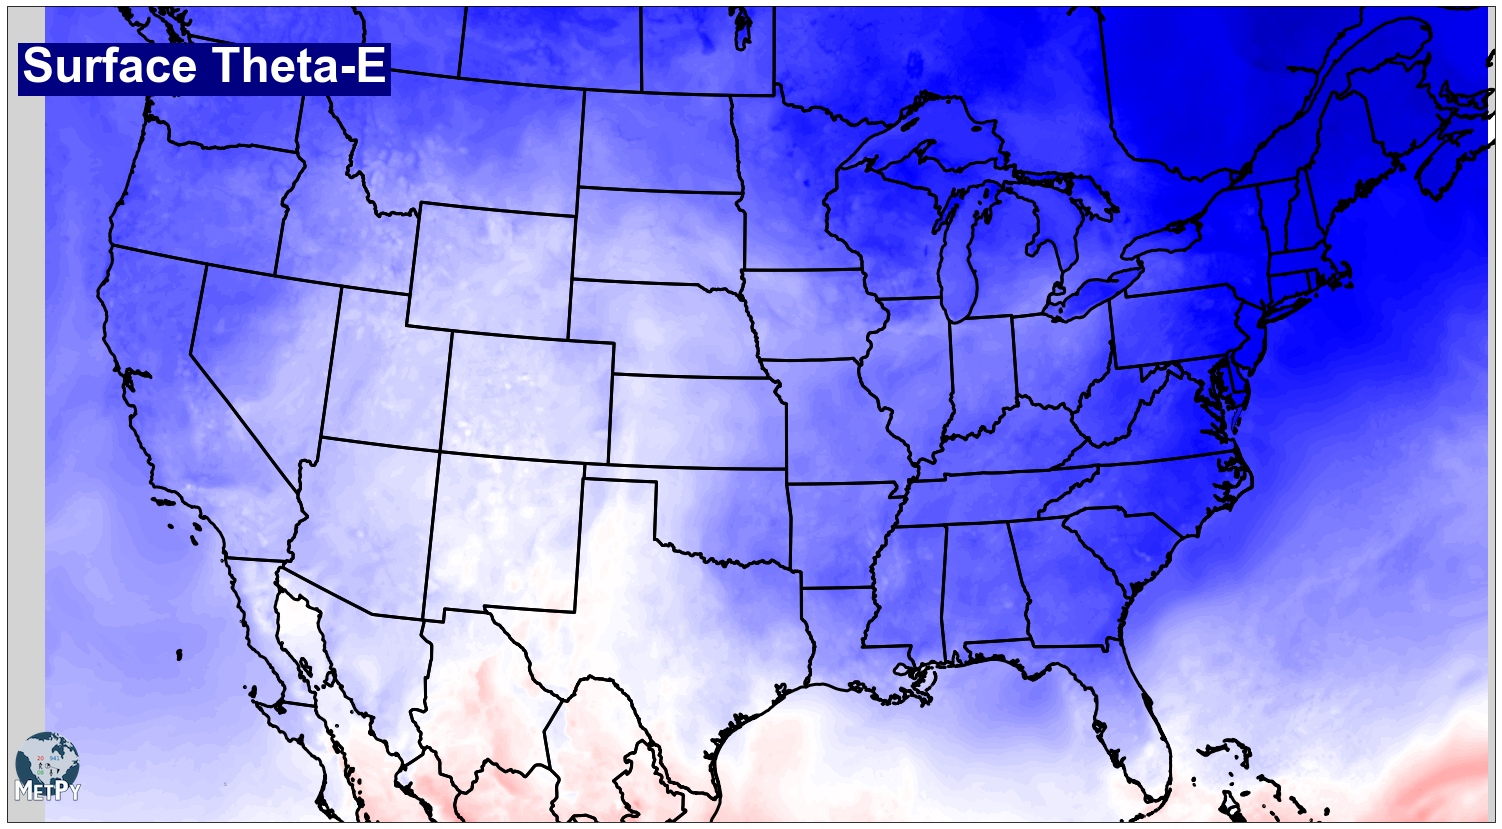

In [7]:
fig = plt.figure(figsize=(1920/72, 1080/72))
ax = fig.add_subplot(1, 1, 1, projection=plot_proj)
ax.set_extent((-122, -70, 25, 50), crs=ccrs.PlateCarree())

# Add state lines, coastlines, map extent
ax.add_feature(cfeature.OCEAN.with_scale('10m'), color='lightgray')
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.75)
ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=3.00)
ax.set_adjustable('datalim')

# Display Banner
plt.text(0.01, 0.95, s='Surface Theta-E',
         fontname='Arial', fontsize=48, fontweight='bold', color='white',
         bbox={'facecolor': 'navy', 'alpha': 1.0, 'edgecolor': 'none'},
         transform=ax.transAxes, zorder=10, va='top')

# ax.contourf(temp.metpy.x, temp.metpy.y, temp - 273.15,
#             transform=temp.metpy.cartopy_crs,
#             levels=np.arange(-30, 40, 4), cmap='coolwarm')

ax.contourf(thetae.metpy.x, thetae.metpy.y, thetae,
            levels=np.arange(240, 400, 1), cmap=plt.cm.seismic,
            transform=thetae.metpy.cartopy_crs)

mpplots.add_metpy_logo(fig)